# Contenuti
- [Import](#Import)
- [Dataset casuale](#Dataset-casuale)
- [Esempio con scikit-learn](#Esempio-con-scikit-learn)
- [Implementazione K-means](#Implementazione-K-means)
    - [Selezione casuale dei centroidi iniziali](#Selezione-casuale-dei-centroidi-iniziali)
    - [Assegnazione dei pattern](#Assegnazione-dei-pattern)
    - [Aggiornamento dei centroidi](#Aggiornamento-dei-centroidi)
    - [K-means](#K-means)
    - [Esecuzione](#Esecuzione)
- [Trovare il numero di profumi presenti](#Trovare-il-numero-di-profumi-presenti)
    - [Dataset](#Dataset)
    - [Esercizio](#Esercizio)

# Esercitazione 6
Nell'esercitazione odierna si implementerà l'algoritmo *K-means*. Verrà chiesto di implementarne le parti fondamentali, verificarne il corretto funzionamento e infine di utilizzare l'algoritmo sviluppato per risolvere un problema di clustering.

# Import
Per prima cosa è necessario eseguire l'import delle librerie utilizzate durante l'esecitazione.

In [120]:
%matplotlib inline
########
# Nota: se appare un warning relativo a un memory leak su Windows,
# decommentare le seguenti 2 righe di codice:
import os
os.environ['OMP_NUM_THREADS'] = '2'
########

import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.spatial.distance import cdist
import ml_utilities
import ml_visualization
from sklearn.metrics import silhouette_score


# Dataset casuale
Durante la fase di implementazione del *K-means* verrà utilizzato un dataset di esempio generato casualmente per poter verificare in maniera semplice il corretto funzionamento dell'algoritmo.

Scikit-learn mette a disposizione la funzione [**make_blobs(...)**](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) per generare raggruppamenti di punti con distribuzione gaussiana. Variando i parametri *n_samples* (numero totale di punti generati), *centers* (numero di raggruppamenti) e *random_state* (seme iniziale per la generazione casuale) è possibile ottenere dataset differenti.

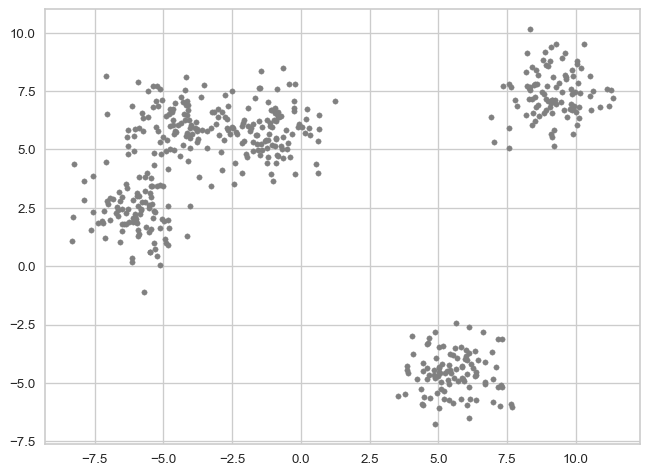

In [95]:
# Generazione di un dataset casuale
from sklearn.datasets import make_blobs

data, _ = make_blobs(n_samples=500, centers=5, random_state=1234)

plt.figure(num=0, dpi=96, figsize=(8, 6))
plt.scatter(data[:,0], data[:,1], c='grey', marker='o', s=16)
plt.show()

# Esempio con scikit-learn
La libreria Scikit-learn fornisce un'implementazione dei più importanti algoritmi di clustering. Per maggiori informazioni si rimanda alla [documentazione ufficiale](https://scikit-learn.org/stable/modules/clustering.html).

Di seguito un esempio di come utilizzare l'algoritmo *K-means* di Scikit-learn sul dataset appena generato.

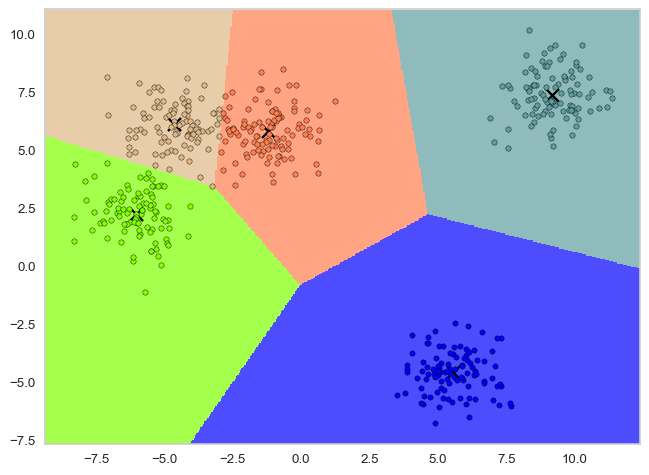

In [96]:
# Import della libreria
from sklearn.cluster import KMeans

# Definizione del numero di cluster attesi
n_clusters = 5

# Creazione dell'istanza di KMeans e addestramento
kmeans = KMeans(n_clusters=n_clusters, random_state=1234, n_init=1)
kmeans.fit(data)

# Visualizzazione dei risultati
plt.figure(num=0, dpi=96, figsize=(8, 6))
ml_visualization.draw_clustering_decision_boundaries(data, kmeans.labels_, kmeans.cluster_centers_, step=0.05)
plt.show()

È possibile ottenere i centroidi dei vari cluster utilizzando l'attributo **cluster\_centers\_** come mostrato nell'esempio seguente:

In [97]:
print('Centroidi ottenuti:\n', kmeans.cluster_centers_)

Centroidi ottenuti:
 [[ 5.55839454 -4.58597761]
 [-4.66176462  6.11242732]
 [ 9.18060111  7.38707618]
 [-6.03528591  2.24620235]
 [-1.22580751  5.80682798]]


Come per i classificatori, in Scikit-learn gli algoritmi di clustering mettono a disposizione il metodo **.predict(...)** che permette di ottenere l'indice del cluster a cui un pattern viene assegnato.

In [98]:
# Esempio di uso della funzione predict
print('Cluster predetti:\n', kmeans.predict([[-2.5, 0.0], [2.5, -4.0], [0.0, 5.0]]))

Cluster predetti:
 [3 0 4]


# Implementazione K-means
Per poter sviluppare la nostra versione dell'algoritmo si dovranno implementare le seguenti funzioni:
- **assign_patterns_to_clusters(...)** che restituisca un vettore contenente l’indice del cluster a cui è stato assegnato ogni pattern del dataset.
- **compute_centroids(...)** che dovrà restituire i nuovi centroidi calcolati come media dei pattern appartenenti ad ogni cluster.

Queste funzioni verranno successivamente richiamate all'interno della funzione **kmeans_execution(...)** che implementa l'intero *K-means*.

## Selezione casuale dei centroidi iniziali
Il primo passo del *K-means* richiede che vengano scelti casualmente $s$ (numero di cluster) pattern da utilizzare come centroidi iniziali.

La funzione **select_random_centroids(...)** restituisce $s$ centroidi scelti casualmente dai pattern di *data*. Sia il parametro *data* che il valore di ritorno sono **ndarray** bidimensionali in cui i pattern sono memorizzati per riga.

Nota: il parametro *seed* viene utilizzato per l’inizializzazione del generatore di numeri casuali. Per ulteriori dettagli si faccia riferimento alla documentazione della libreria [**random**](https://docs.python.org/3.6/library/random.html). A parità di *seed* il risultato della funzione non cambia in esecuzioni successive. La funzione **random.sample(...)** permette di selezionare un sottoinsieme di elementi da una lista (risolve il problema di selezionare più volte lo stesso elemento).

In [99]:
# La funzione restituisce s centroidi scelti casualmente tra i pattern di data

# data: ndarray bidimensionale in cui i pattern sono memorizzati per riga. Shape = (n_patterns, 2)
# s: numero intero, indica il numero di centroidi da selezionare
# seed: numero intero, utilizzato per inizializzare il generatore di numeri casuali

# Risultato: ndarray bidimensionale in cui i centroidi sono memorizzati per riga. Shape = (s, 2)

def select_random_centroids(data, s, seed):
    random.seed(seed)
    centroid_indices = random.sample(range(data.shape[0]), s)
    return data[centroid_indices]

## Assegnazione dei pattern
Ad ogni iterazione i pattern del dataset devono essere assegnati al cluster per cui è minima la distanza dal corrispondente centroide.

Si implementi la funzione **assign_patterns_to_clusters(...)** che restituisca un **ndarray** monodimensionale (*labels*) contenente l’indice del cluster a cui è stato assegnato ogni pattern. Per individuare il centroide più vicino ad ogni pattern è possibile utilizzare la funzione **compute_square_euclidean_distance(...)** già disponibile nella libreria ml_utilities.

Inoltre si dovrà calcolare e restituire la somma dei quadrati delle distanze di tutti i pattern $\boldsymbol{x}$ dai centroidi a cui sono stati assegnati (*sum_square_distances*), indicata con $J_e$:

$\Large{J_e = \sum_{i=1...s} \sum_{\boldsymbol{x} \in C_i} \lVert \boldsymbol{x} - \boldsymbol{\overline{x}_i} \rVert^2}$

$\Large{\boldsymbol{\overline{x}_i} = \frac{1}{n_i} \sum_{\boldsymbol{x} \in C_i} \boldsymbol{x}}$

dove $C_i$ è l'i-esimo cluster, $n_i$ il numero di pattern che contiene e $\boldsymbol{\overline{x}_i}$ il suo centroide (media).

In [100]:
# Esercizio 1: si completi il codice della funzione assign_patterns_to_clusters
# La funzione deve restituire un vettore contenente l'indice del cluster a cui
# è stato assegnato ogni pattern

# data: ndarray bidimensionale in cui i pattern sono memorizzati per riga. Shape = (n_patterns, 2)
# centroids: ndarray bidimensionale in cui i centroidi sono memorizzati per riga. Shape = (s, 2)

# Risultato 1: ndarray monodimensionale in cui sono memorizzate le etichette dei pattern. Shape = (n_patterns,)
# Risultato 2: valore numerico, somma dei quadrati delle distanze dei pattern dai centroidi a cui sono assegnati

def assign_patterns_to_clusters(data, centroids):
    labels = np.zeros((data.shape[0]))
    labels = np.argmin([[ml_utilities.compute_square_euclidean_distance(d, c) for c in centroids] for d in data], axis=1)

    distances_squared = np.zeros(data.shape[0])

    for idx, (d, label) in enumerate(zip(data, labels)):
        centroid = centroids[int(label)]
        distance_squared = ml_utilities.compute_square_euclidean_distance(d, centroid)
        distances_squared[idx] = distance_squared

        # Calcola la somma delle distanze quadrate
        sum_square_distances = np.sum(distances_squared)
    
    return labels, sum_square_distances


## Aggiornamento dei centroidi
Una volta assegnati i pattern ai rispettivi cluster è necessario calcolare i nuovi centroidi come media dei pattern appartenenti ad ogni cluster.

Si implementi la funzione **compute_centroids(...)** in modo tale che questa restituisca un **ndarray** bidimensionale (*centroids*) contenente i nuovi centroidi (memorizzati per riga).

In [101]:
# Esercizio 2: si completi il codice della funzione compute_centroids
# La funzione deve restituire i nuovi centroidi calcolati come media
# dei pattern appartenenti ad ogni cluster

# data: ndarray bidimensionale in cui i pattern sono memorizzati per riga. Shape = (n_patterns, 2)
# labels: ndarray monodimensionale in cui sono memorizzate le etichette dei pattern. Shape = (n_patterns,)
# s: numero intero, indica il numero di centroidi da selezionare

# Risultato: ndarray bidimensionale in cui i centroidi sono memorizzati per riga. Shape = (s, 2)

def compute_centroids(data, labels, s):
    centroids = np.zeros((s, data.shape[1]))
    count = np.zeros((s, 1))

    for d, label in zip(data, labels):
        centroids[label] += d
        count[label] += 1

    for idx in range(s):
        if count[idx] != 0:
            centroids[idx] /= count[idx]
        
    return centroids



## K-means
Le parti appena implementate costituiscono i blocchi fondamentali su cui si basa l'algoritmo *K-means*. La cella seguente definisce la funzione **kmeans_execution(...)** che, utilizzando le funzioni appena sviluppate, esegue l'algoritmo restituendo:

- l'indice del cluster a cui è stato assegnato ogni pattern di input (*labels*);
- la lista dei centroidi di ogni cluster (*centroids*);
- la somma dei quadrati delle distanze (*sum_square_distances*);
- il numero di iterazioni eseguite (*iteration_count*).

In [102]:
def kmeans_execution(data, s, max_iteration_count, seed):
    centroids = select_random_centroids(data, s, seed)
    iteration_count = 0
    modified = True
    while modified and iteration_count < max_iteration_count:
        labels, sum_square_distances = assign_patterns_to_clusters(data, centroids)
        new_centroids = compute_centroids(data, labels, s)
        modified = not np.array_equal(centroids, new_centroids)
        centroids = new_centroids
        iteration_count += 1

    return labels, centroids, sum_square_distances, iteration_count

## Esecuzione
Il codice contenuto nella cella seguente richiama la funzione **kmeans_execution(...)** sul dataset generato in precedenza e ne visualizza i risultati.

Si verifichi il funzionamento dell’algoritmo al variare del numero di cluster ($s$), del seme per la scelta casuale dei centroidi iniziali (*seed*) e del massimo numero di iterazioni consentite (*max_iteration_count*).

Somma quadrati distanze: 898.827
Numero di iterazioni: 8


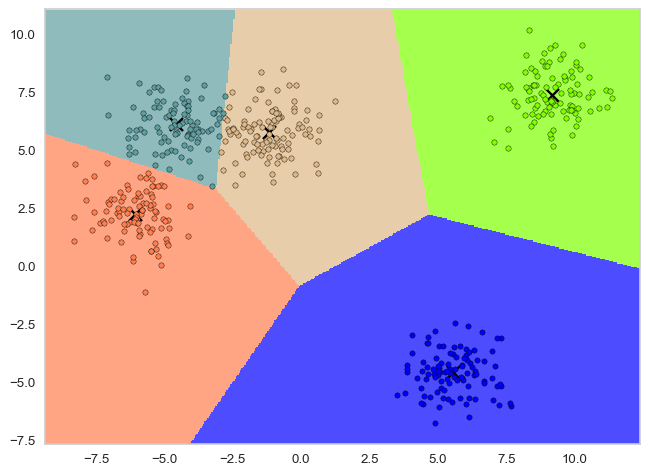

In [103]:
s = 5
seed = 1234
max_iteration_count = 1024

labels, centroids, sum_square_distances, iteration_count = kmeans_execution(data, s, max_iteration_count, seed)

print('Somma quadrati distanze: %0.3f' % sum_square_distances)
print('Numero di iterazioni:', iteration_count)

plt.figure(num=0, dpi=96, figsize=(8, 6))
ml_visualization.draw_clustering_decision_boundaries(data, labels, centroids, step=0.05)
plt.show()

# Trovare il numero di profumi presenti
Si utilizzi l’algoritmo *K-means* appena implementato per stimare il numero corretto di raggruppamenti (cluster) presenti in un dataset non etichettato.

## Dataset
Il dataset "Profumi.txt" contiene un insieme di pattern bidimensionali non etichettati acquisiti analizzando con due sensori di odore un insieme di profumi. Di seguito è riportata la procedura per il caricamento del dataset:

Shape del dataset: (490, 2)


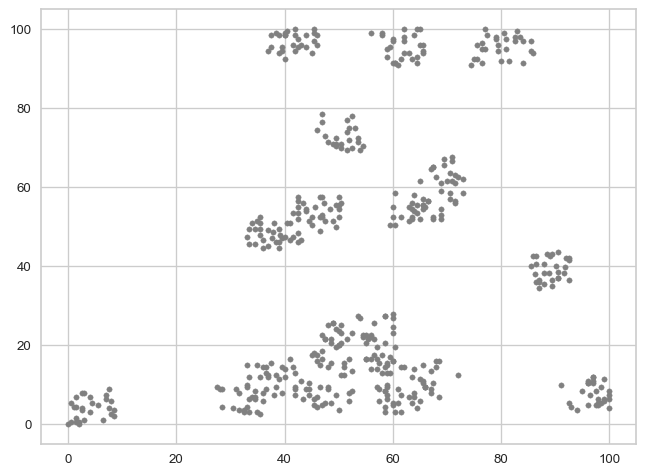

In [104]:
dataset_file_path = 'DBs/Profumi/Profumi.txt'
data = np.loadtxt(dataset_file_path)

print('Shape del dataset:', data.shape)

plt.figure(num=0, dpi=96, figsize=(8, 6))
plt.scatter(data[:,0], data[:,1], c='gray', marker='o', s=16)
plt.show()

## Esercizio

Stimare il numero di profumi analizzati utilizzando l’algoritmo *K-means*. 

Si completi il codice riportato nella cella seguente al fine di eseguire l’algoritmo *K-means* per i diversi valori del numero di cluster ($s$) nell’intervallo \[*s_min*, *s_max*\]. Per evitare che il risultato ottenuto possa essere condizionato da una scelta errata dei centroidi iniziali, consigliamo di eseguire l'algoritmo più volte (*execution_count*) per ogni valore di $s$. Al fine di evitare di ottenere risultati identici, a ogni esecuzione è necessario partire da un insieme di centroidi iniziali differente. Pertanto, il codice genera una matrice di seed diversi (*seeds*) da utilizzare nelle diverse esecuzioni di *K-means*.

Al termine dell’intera esecuzione viene mostrato il grafico del valore minimo di $J_e$ (su *execution_count* esecuzioni per ogni $s$) al variare di $s$. Al fine di rendere possibile la visualizzazione di questi valori è necessario memorizzare nella variabile $y$ il valore minimo di $J_e$ trovato per ogni $s$ (su tutte le esecuzioni - *execution_count*).

Dovendo eseguire il *K-means* un elevato numero di volte, sottenutai consiglia di utilizzare la versione di Scikit-learn perchè più efficiente rispetto alla versione appena implementata. La classe [**KMeans**](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) mette a disposizione gli attributi **inertia\_** e **n\_iter\_** che restituiscono rispettivamente il valore $J_e$ della soluzione ottenuta e il numero di iterazioni eseguite.

Nota: per questi esperimenti, considerato che l'esecuzione ripetuta di KMeans è già controllata dal ciclo su *execution_count*, è conveniente passare a *KMeans* il parametro `n_init=1` (si veda [la documentazione](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)).

[0.62251895 0.62251895 0.62251895 0.62251895 0.62251895 0.62251895
 0.62251895 0.62251895 0.62251895 0.62251895 0.62251895]
[815965. 191984. 279397.  28446. 519943. 984713. 468368. 995628. 160495.
 960003. 291525.]


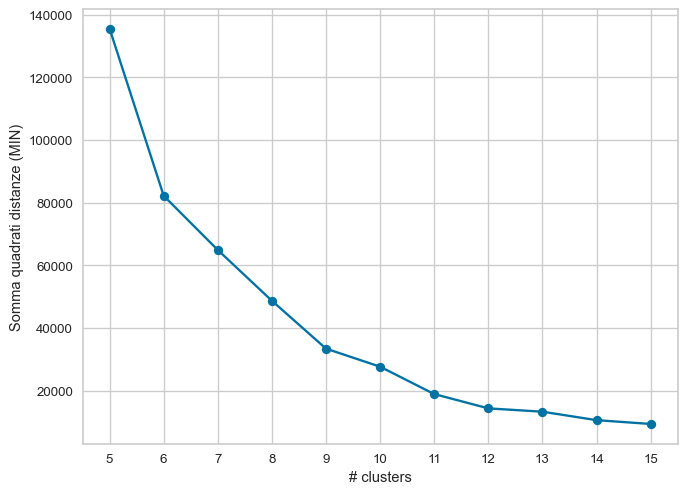

In [122]:
# Esercizio 3: si individui il numero di cluster ottimale nei
# due differenti scenari [5, 15] e [16, 25] modificando i
# successivi parametri, completando il codice e analizzando l'output

s_min = 5
s_max = 15
execution_count = 30
initial_seed = 1234
max_iteration_count = 50



random.seed(initial_seed)
s = np.array(range(s_min, s_max + 1))
y = np.zeros(s.shape[0])

distortions = np.zeros(s.shape[0])
mapping1 = {}
mapping2 = {}
silhouette_avg = np.zeros(s.shape[0])
seeds = np.zeros((s.shape[0], execution_count), dtype=int)
c_seed = np.empty(s.shape[0])
for i in range(s.shape[0]):
    for j in range(execution_count):
        seeds[i, j] = random.randint(0, 1000000)
        kmeanModel = KMeans(n_clusters=s[i], random_state=seeds[i, j], n_init=1)
        kmeanModel.fit(data)
        if silhouette_avg[i] == 0 or silhouette_avg[i]<silhouette_score(data, kmeanModel.labels_):
            distortions[i] = sum(np.min(cdist(data, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / data.shape[0]
            y[i] = kmeanModel.inertia_
            silhouette_avg[i] = silhouette_score(data, kmeanModel.labels_)

            mapping1[i] = sum(np.min(cdist(data, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / data.shape[0]
            mapping2[i] = kmeanModel.inertia_
            c_seed[i]=seeds[i,j]

    
 
    
print(silhouette_avg)
print(c_seed)
plt.figure(num=0, dpi=96, figsize=(8, 6))
plt.plot(s, y, marker='o')
plt.xticks(range(s_min, s_max+1))
plt.xlabel('# clusters')
plt.ylabel('Somma quadrati distanze (MIN)')
plt.show()


Si individui il numero di profumi presenti nel dataset analizzando il grafico. Si faccia attenzione al fatto che, per come è definito $J_e$, valori grandi di $s$ producono più facilmente valori piccoli di $J_e$.

Pertanto per determinare il numero ottimale di cluster (validation) si suggerisce di:

- analizzare il grafico alla ricerca di punti di discontinuità (*elbow*);
- utilizzare *silhouette analysis* (*silhouette score* e *diagram*) presenti in Scikit-learn. Vedi:
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py


Il codice seguente può essere utilizzato come ulteriore supporto per l'individuazione dell'esatto numero di profumi analizzando visivamente le singole soluzioni ottenute al passo precedente.

0.6225189469729081


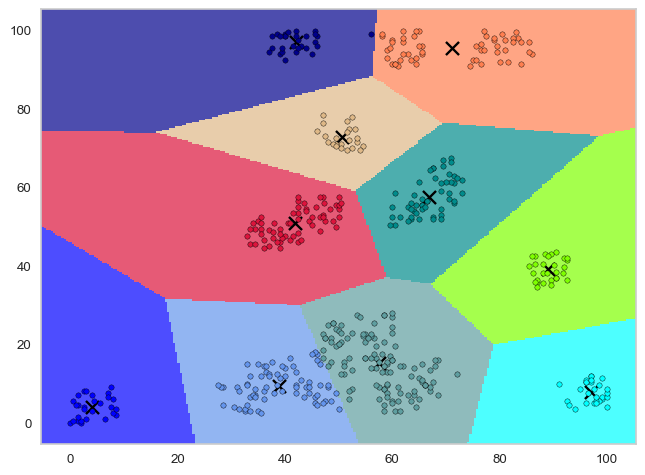

In [121]:
s = 10
seed = 395124
kmeans = KMeans(n_clusters=s, random_state=seed, n_init=1)
kmeans.fit(data)



plt.figure(num=0, dpi=96, figsize=(8, 6))
ml_visualization.draw_clustering_decision_boundaries(data, kmeans.labels_, kmeans.cluster_centers_, step=0.4)
plt.show()

In particolare, riportare il numero reale di profumi nel caso in cui $s$ sia compreso tra 5 e 15 e nel caso in cui sia compreso tra 16 e 25.

Memorizzare i due valori di $s$ in un file di testo dal nome "Es6Predictions.txt" (un valore per riga). La cella seguente genera, date le stime di $s_1 \in [5, 15]$ e $s_2 \in [16, 25]$, il file di testo correttamente formattato.

In [117]:
# Assegnare a s_1 e s_2 i valori trovati 
s_1 = 9
s_2 = 19

# Creazione del file di testo
result_path = 'Es6Predictions.txt'
s_values = np.array([s_1, s_2], dtype=int)
np.savetxt(result_path, s_values, fmt='%i')
print('Ok')

Ok
